In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

2024-02-24 12:26:46.959122: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 12:26:47.210622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 12:26:47.210692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 12:26:47.250532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 12:26:47.336441: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version 2.15.0
GPU is ON


2024-02-24 12:26:50.373966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 12:26:50.505843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 12:26:50.506090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Prepare input training data

In [8]:
CLASSES = 8

COLORS = ['black', 'red', 'lime',
          'blue', 'orange', 'pink',
          'cyan', 'magenta']

SAMPLE_SIZE = (256, 256)

OUTPUT_SIZE = (1080, 1920)

In [3]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    masks = []

    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))

    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)

    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)

    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

In [4]:
images = sorted(glob.glob('dataset/images/*.jpg'))
masks = sorted(glob.glob('dataset/masks/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

2024-02-24 12:26:54.659558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 12:26:54.659725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 12:26:54.659790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## visualisation with object boarders

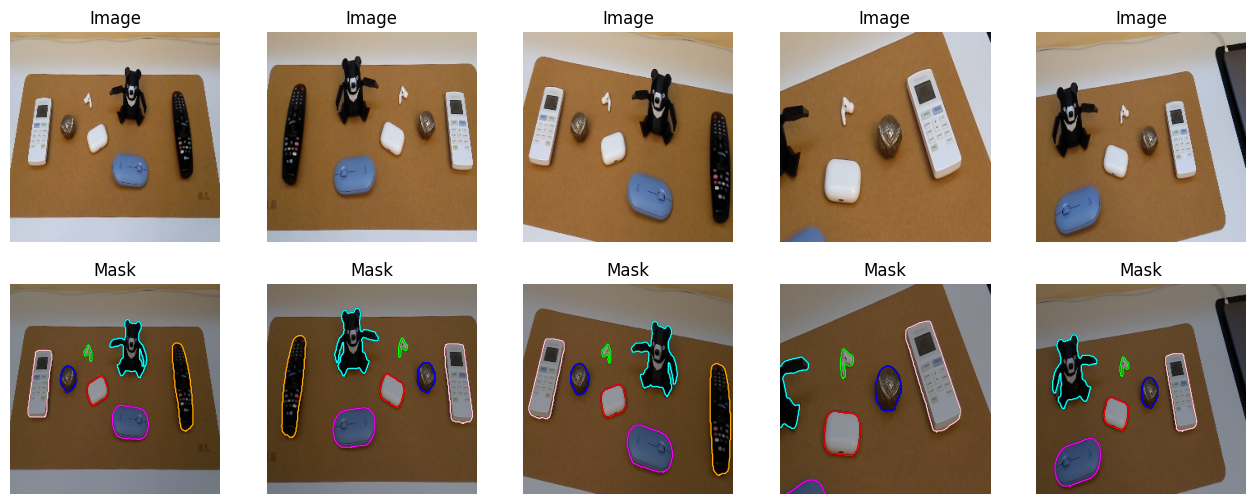

In [5]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 6))

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

In [6]:
len(images_and_masks)

5

## train valid split

In [7]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()
 
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

## building UNET

In [11]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(inputs, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    # s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p3, 64)

    """ Decoder """
    # d1 = decoder_block(b1, s4, 512)
    d1 = decoder_block(b1, s3, 64)
    d2 = decoder_block(d1, s2, 32)
    d3 = decoder_block(d2, s1, 16)

    outputs = tf.keras.layers.Conv2D(CLASSES, 1, padding='same', activation='sigmoid')(d3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [12]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)

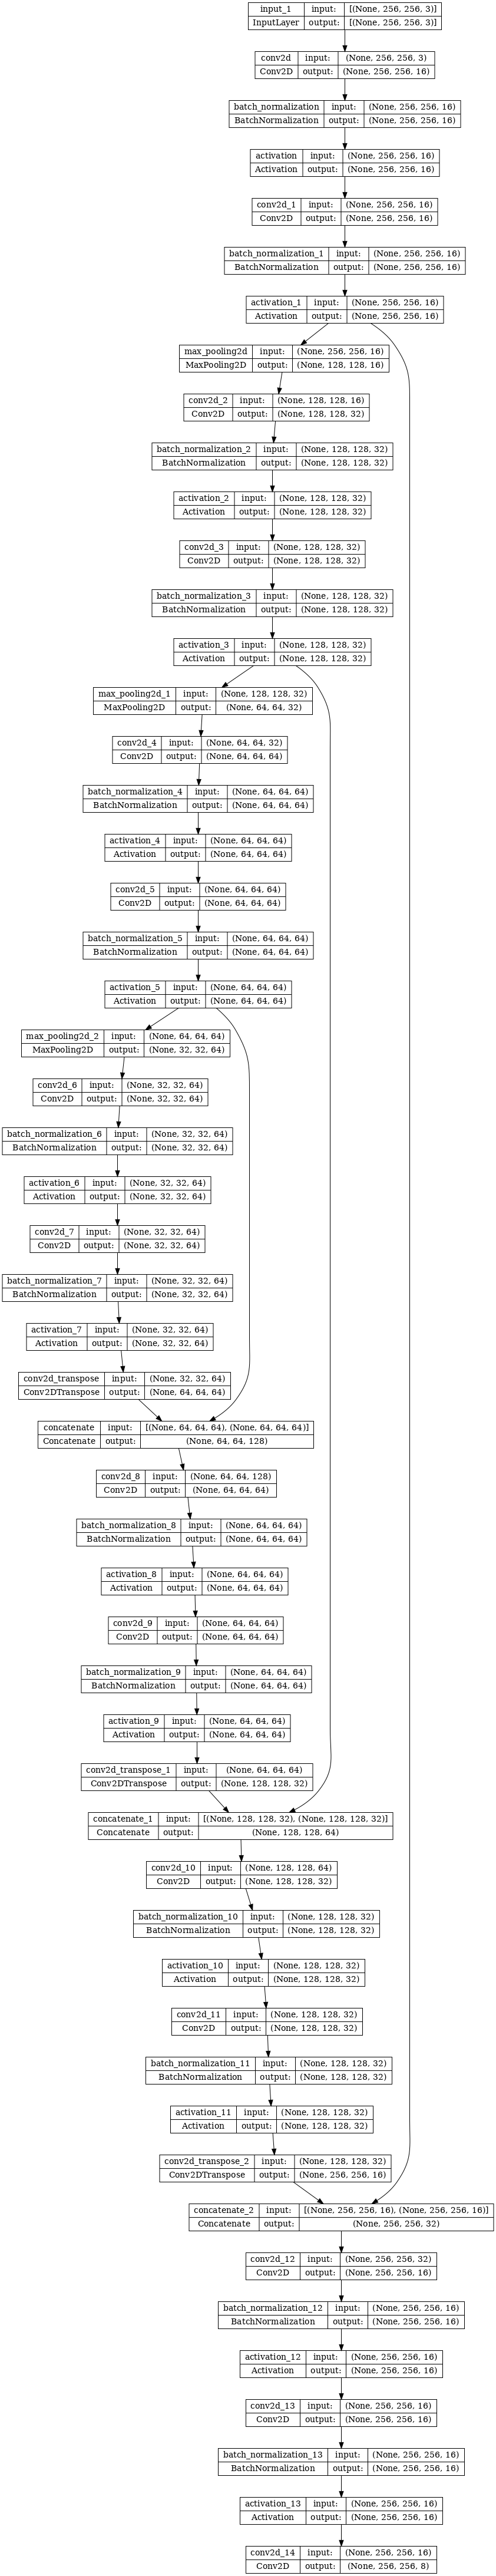

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=72)

## define loss function

In [14]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [15]:
model.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Training model

In [16]:
history_dice = model.fit(train_dataset, validation_data=test_dataset, epochs=25, initial_epoch=0)

model.save_weights('SemanticSegmentationLesson/networks/unet_like')

Epoch 1/25


2024-02-24 12:31:41.971590: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-24 12:31:42.498441: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-24 12:31:43.078611: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-24 12:31:47.466336: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe299bf78f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 12:31:47.466358: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-24 12:31:47.479440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708803107.548034   10136 devic

250/250 [==============================] - 238s 878ms/step - loss: 0.5595 - dice_mc_metric: 0.2353 - val_loss: 0.4583 - val_dice_mc_metric: 0.1559
Epoch 2/25
250/250 [==============================] - 31s 125ms/step - loss: 0.2010 - dice_mc_metric: 0.5450 - val_loss: 0.1440 - val_dice_mc_metric: 0.6535
Epoch 3/25
250/250 [==============================] - 31s 126ms/step - loss: 0.0905 - dice_mc_metric: 0.7673 - val_loss: 0.0672 - val_dice_mc_metric: 0.8262
Epoch 4/25
250/250 [==============================] - 32s 126ms/step - loss: 0.0494 - dice_mc_metric: 0.8771 - val_loss: 0.1334 - val_dice_mc_metric: 0.7933
Epoch 5/25
250/250 [==============================] - 32s 127ms/step - loss: 0.0262 - dice_mc_metric: 0.9384 - val_loss: 0.0468 - val_dice_mc_metric: 0.9134
Epoch 6/25
250/250 [==============================] - 32s 127ms/step - loss: 0.0207 - dice_mc_metric: 0.9535 - val_loss: 0.0211 - val_dice_mc_metric: 0.9530
Epoch 7/25
250/250 [==============================] - 32s 127ms/step

In [17]:
model.load_weights('SemanticSegmentationLesson/networks/unet_like')

## validation on video frames

In [ ]:
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('videos/original_video/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = model.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(1, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                
                contour_overlay[rr, cc] = 1        
            
            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'videos/processed/{os.path.basename(filename)}', frame)

1/1 [==============================] - 0s 15ms/step
